# House Price Prediction

## 1. Project Overview

**Objective:** 

To predict house prices based on various features using multiple regression models and identify the optimal model based on performance metrics.

**Scope:** 

The prediction is limited by the location encompassed in the dataset. The dataset only covers western United States and would require data on other parts to properly generalize to the whole country.

**Dataset:** 

The dataset contains information on housing in the western United States, including features such as median income, total rooms, population, and ocean proximity.

**Steps:**

**Data Cleaning:** Addressed missing values by dropping rows with missing data and standardized feature ranges.
Exploratory Data Analysis (EDA): Conducted univariate and multivariate analysis to understand feature distributions, correlations, and the impact of categorical variables on house prices.

**Feature Engineering**: Created additional features such as rooms per household and population per household to enhance model performance.

**Data Preprocessing:** Applied one-hot encoding to categorical variables and standardized numerical features.
Modeling: Evaluated several regression models, including Linear Regression, Decision Tree Regressor, Random Forest Regressor, Gradient Boosting Regressor, and Support Vector Regressor.

**Evaluation**: Compared models using Mean Squared Error (MSE), R-squared (R2), and runtime. Gradient Boosting was identified as the optimal model due to its balanced performance across metrics.

**Outcome**: Gradient Boosting emerged as the most effective model for predicting house prices, achieving the best trade-off between prediction accuracy and computational efficiency.

## Imports

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import time

## Pipeline

In [2]:
# Define functions for various steps in the pipeline

def load_data(filepath):
    """
    Load the housing dataset from a CSV file.
    
    Parameters:
    filepath (str): Path to the CSV file.
    
    Returns:
    pd.DataFrame: Loaded dataset.
    """
    return pd.read_csv(filepath)

def inspect_data(df):
    """
    Inspect the dataset by printing its shape, info, and description.
    
    Parameters:
    df (pd.DataFrame): DataFrame to inspect.
    """
    print('Shape:')
    print(df.shape)
    print('Info:')
    print(df.info())
    print('Description:')
    print(df.describe())

def handle_missing_values(df):
    """
    Handle missing values in the dataset by dropping rows with missing 'total_bedrooms'.
    
    Parameters:
    df (pd.DataFrame): DataFrame with missing values.
    
    Returns:
    pd.DataFrame: DataFrame with missing values handled.
    """
    return df.dropna(subset=['total_bedrooms'])

def plot_univariate_analysis(df):
    """
    Plot histograms for numerical features and boxplots for outlier analysis.
    
    Parameters:
    df (pd.DataFrame): DataFrame to plot.
    """
    df.hist(bins=50, figsize=(20,15))
    plt.show()
    
    numeric_columns = df.drop(columns='ocean_proximity').columns
    num_plots = len(numeric_columns)
    num_rows = (num_plots // 3) + (num_plots % 3 > 0)
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(18, num_rows * 5))
    axes = axes.flatten()
    
    for i, column in enumerate(numeric_columns):
        sns.boxplot(x=df[column], ax=axes[i])
        axes[i].set_title(column)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

def plot_categorical_analysis(df):
    """
    Plot countplot for the categorical feature 'ocean_proximity' and boxplot against target variable.
    
    Parameters:
    df (pd.DataFrame): DataFrame with categorical features.
    """
    sns.countplot(x='ocean_proximity', data=df)
    plt.title('Frequency Distribution of Ocean Proximity')
    plt.show()
    
    sns.boxplot(x='ocean_proximity', y='median_house_value', data=df)
    plt.title('Ocean Proximity vs Median House Value')
    plt.show()

def plot_scatter_plots(df, features):
    """
    Plot scatter plots of numerical features against the target variable.
    
    Parameters:
    df (pd.DataFrame): DataFrame with numerical features.
    features (list): List of feature column names.
    """
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        sns.scatterplot(x=df[feature], y=df['median_house_value'], ax=axes[i])
        axes[i].set_title(f'{feature} vs Median House Value')
    
    if len(features) % 2 != 0:
        fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(df):
    """
    Plot a heatmap of the correlation matrix.
    
    Parameters:
    df (pd.DataFrame): DataFrame to plot.
    """
    correlation_matrix = df.drop(columns='ocean_proximity').corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

def create_features(df):
    """
    Create additional features to enhance model performance.
    
    Parameters:
    df (pd.DataFrame): DataFrame to augment.
    
    Returns:
    pd.DataFrame: DataFrame with new features.
    """
    df['rooms_per_household'] = df['total_rooms'] / df['households']
    df['population_per_household'] = df['population'] / df['households']
    df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
    return df

def preprocess_data(df):
    """
    Preprocess the data by applying one-hot encoding and standardization.
    
    Parameters:
    df (pd.DataFrame): DataFrame to preprocess.
    
    Returns:
    pd.DataFrame: Scaled DataFrame.
    """
    df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    return pd.DataFrame(df_scaled, columns=df.columns)

def split_data(df):
    """
    Split the data into training and testing sets.
    
    Parameters:
    df (pd.DataFrame): DataFrame to split.
    
    Returns:
    tuple: (X_train, X_test, y_train, y_test)
    """
    X = df.drop(columns=['median_house_value'])
    y = df['median_house_value']
    return train_test_split(X, y, test_size=0.2, random_state=42)

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate multiple regression models.
    
    Parameters:
    X_train (pd.DataFrame): Training features.
    X_test (pd.DataFrame): Testing features.
    y_train (pd.Series): Training target.
    y_test (pd.Series): Testing target.
    
    Returns:
    pd.DataFrame: DataFrame with model evaluation metrics.
    """
    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'Support Vector Regressor': SVR()
    }
    
    model_results = {}
    for model_name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        runtime = end_time - start_time
        
        model_results[model_name] = {'MSE': mse, 'R2': r2, 'Runtime (seconds)': runtime}
    
    return pd.DataFrame.from_dict(model_results, orient='index').reset_index().rename(columns={'index': 'Model'}).sort_values(by='R2', ascending=False)

def plot_model_performance(results_df):
    """
    Plot the performance metrics of the models.
    
    Parameters:
    results_df (pd.DataFrame): DataFrame with model performance metrics.
    """
    models = results_df['Model']
    mse = results_df['MSE'] * 10  # Scale MSE
    r2 = results_df['R2'] * 10  # Scale R2
    runtime = results_df['Runtime (seconds)']
    
    plt.figure(figsize=(12, 6))
    plt.plot(models, mse, marker='o', label='MSE (scaled)', color='blue')
    plt.plot(models, r2, marker='o', label='R2 (scaled)', color='green')
    plt.plot(models, runtime, marker='o', label='Runtime', color='red')
    plt.xlabel('Model')
    plt.ylabel('Value')
    plt.title('Model Performance Metrics')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def normalize_and_evaluate(results_df):
    """
    Normalize and evaluate models based on a combined score of performance metrics.
    
    Parameters:
    results_df (pd.DataFrame): DataFrame with model performance metrics.
    
    Returns:
    pd.Series: Best model based on combined score.
    """
    scaler = MinMaxScaler()
    norm_df = results_df[['MSE', 'R2', 'Runtime (seconds)']].copy()
    norm_df['MSE'] = -norm_df['MSE']
    norm_df['Runtime (seconds)'] = -norm_df['Runtime (seconds)']
    norm_df_scaled = scaler.fit_transform(norm_df)
    
    norm_df_scaled = pd.DataFrame(norm_df_scaled, columns=['MSE', 'R2', 'Runtime (seconds)'])
    norm_df_scaled['Model'] = results_df['Model']
    norm_df_scaled['Score'] = norm_df_scaled['MSE'] + norm_df_scaled['R2'] + norm_df_scaled['Runtime (seconds)']
    
    return norm_df_scaled.loc[norm_df_scaled['Score'].idxmax()]

def main():
    # Load and inspect data
    house = load_data('./datasets/housing.csv')
    inspect_data(house)
    
    # Data Cleaning
    house = handle_missing_values(house)
    
    # Exploratory Data Analysis
    plot_univariate_analysis(house)
    plot_categorical_analysis(house)
    plot_scatter_plots(house, ['total_rooms', 'total_bedrooms', 'population', 'households'])
    plot_correlation_matrix(house)
    
    # Feature Engineering
    house = create_features(house)
    
    # Preprocessing
    house_scaled = preprocess_data(house)
    
    # Splitting Data
    X_train, X_test, y_train, y_test = split_data(house_scaled)
    
    # Training and Evaluation
    results = train_and_evaluate_models(X_train, X_test, y_train, y_test)
    print('Model Evaluation Results:')
    print(results)
    
    # Plot Performance
    plot_model_performance(results)
    
    # Normalize and Evaluate
    best_model = normalize_and_evaluate(results)
    print('Best Model Based on Combined Score:')
    print(best_model)

## Execution

Shape:
(20640, 10)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None
Description:
          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.76308

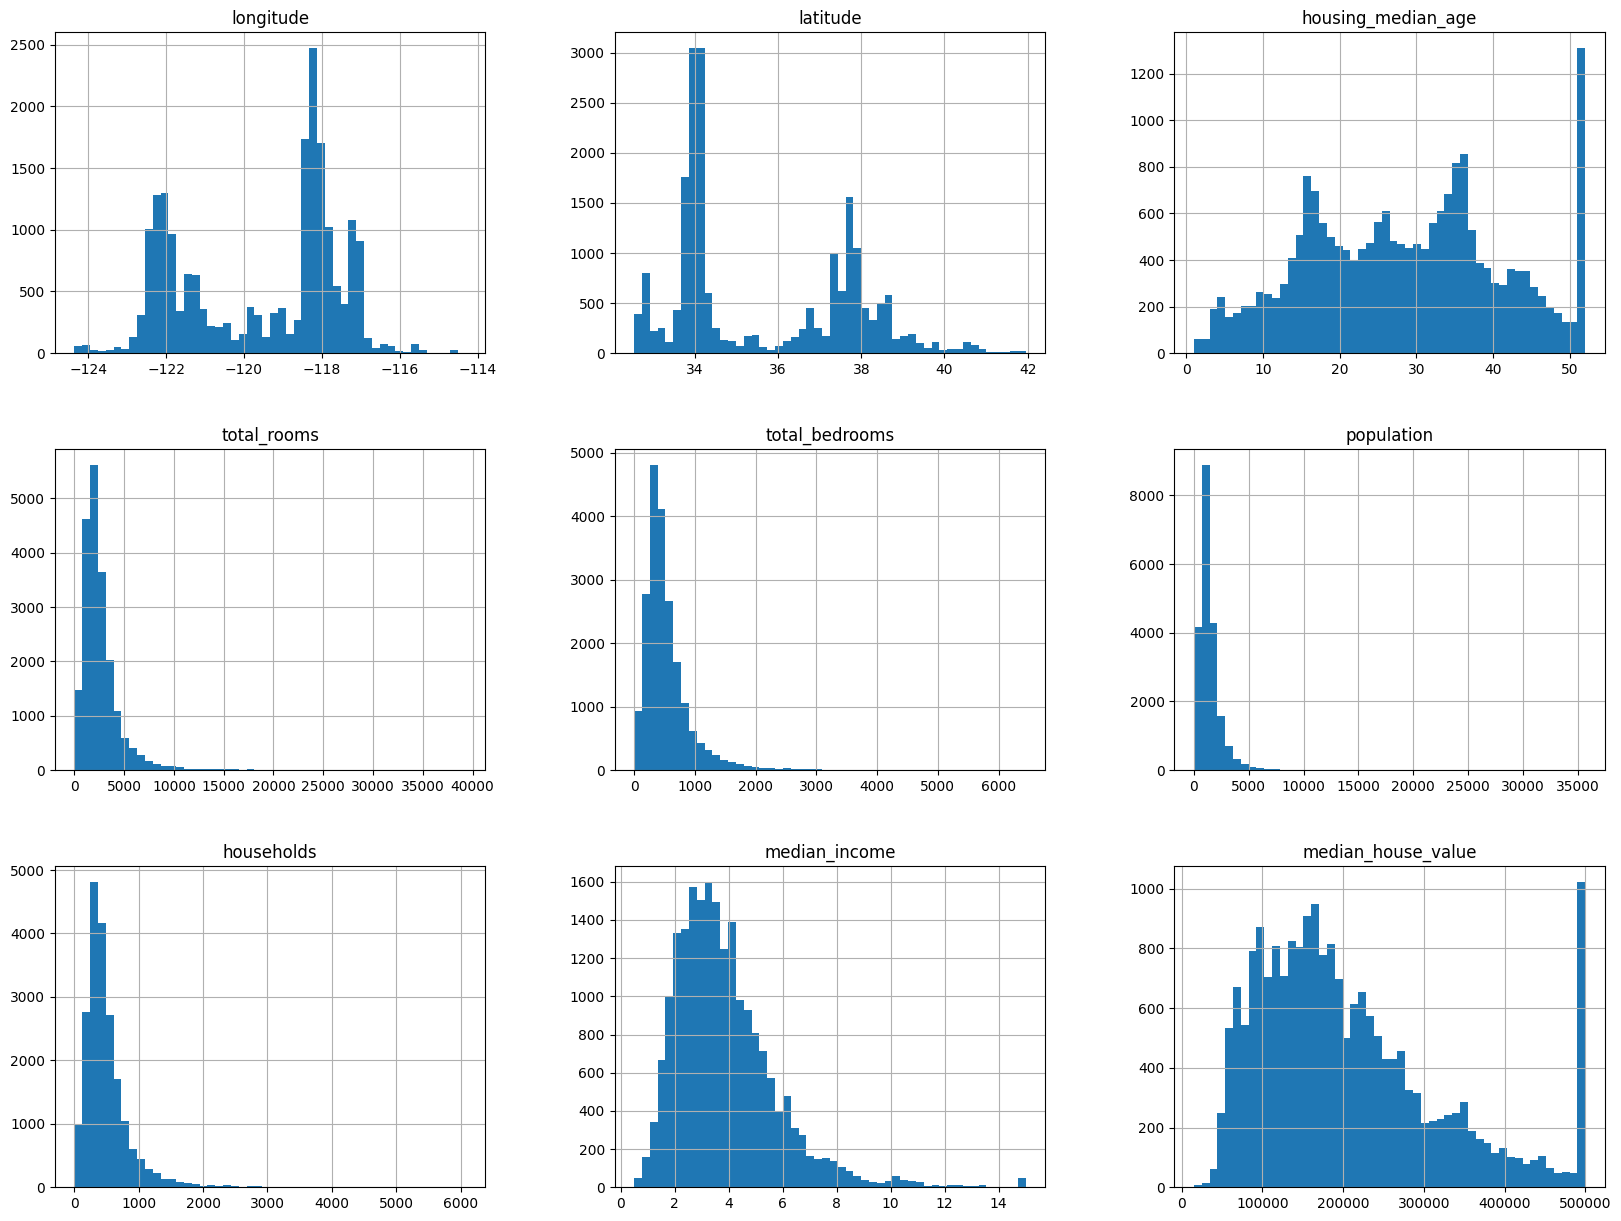

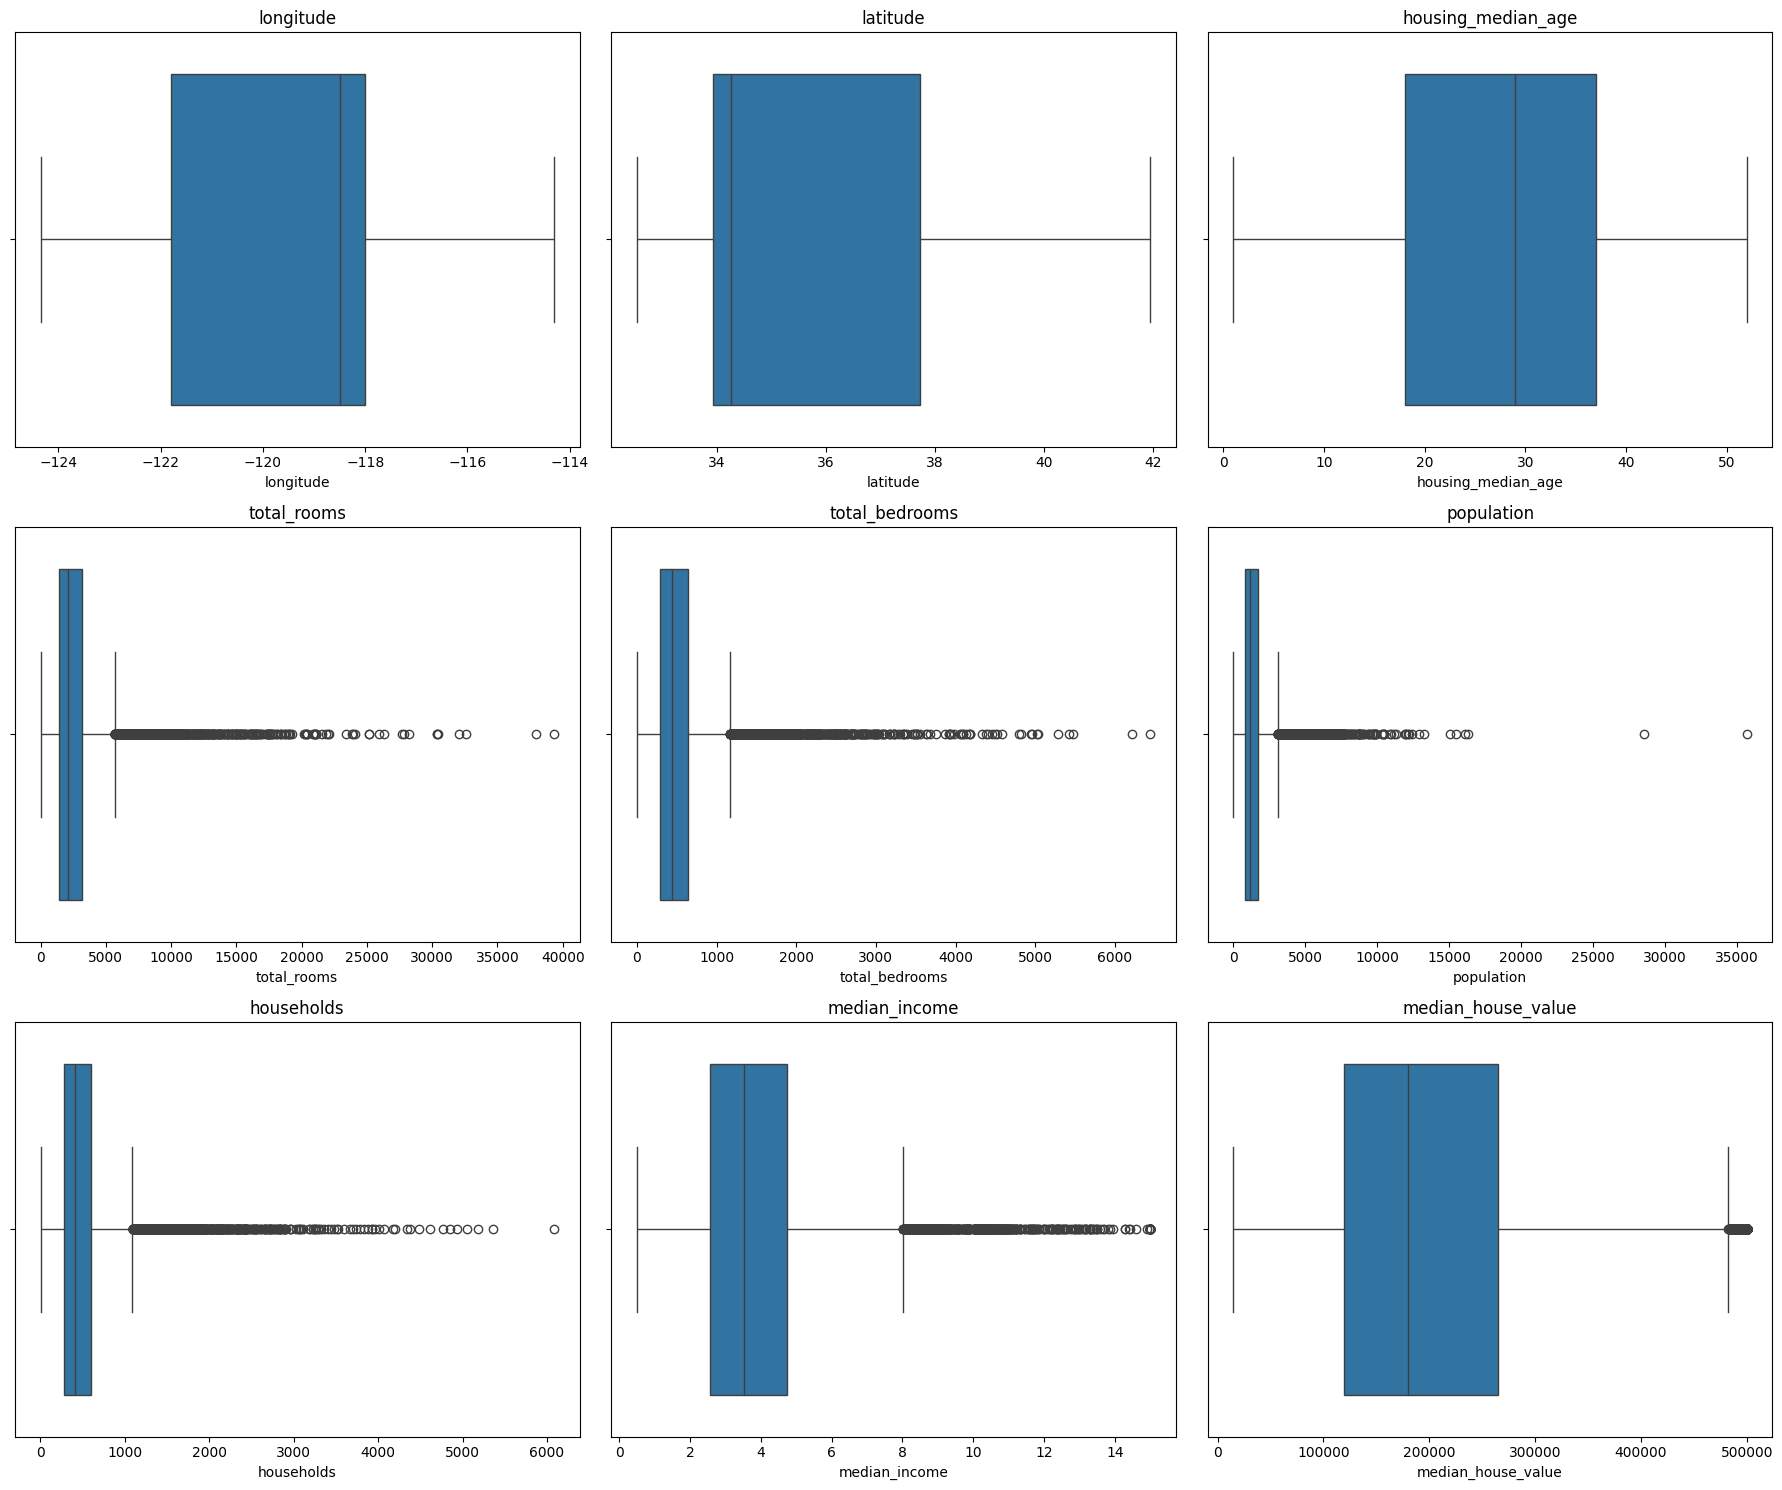

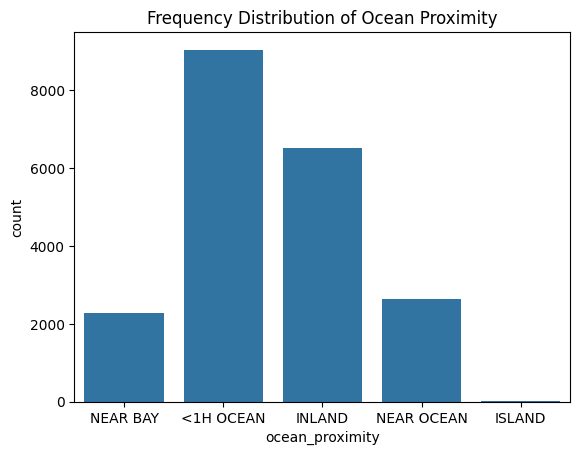

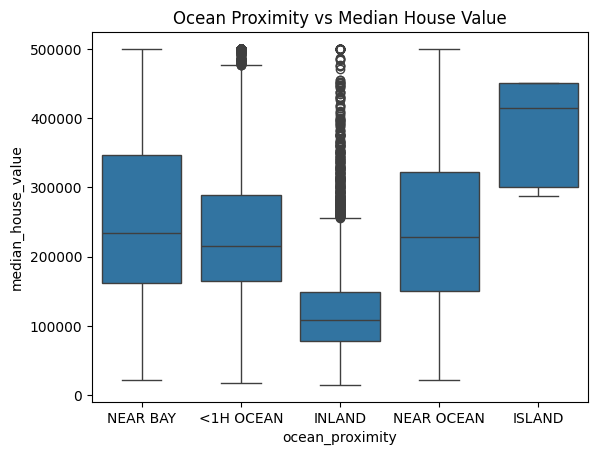

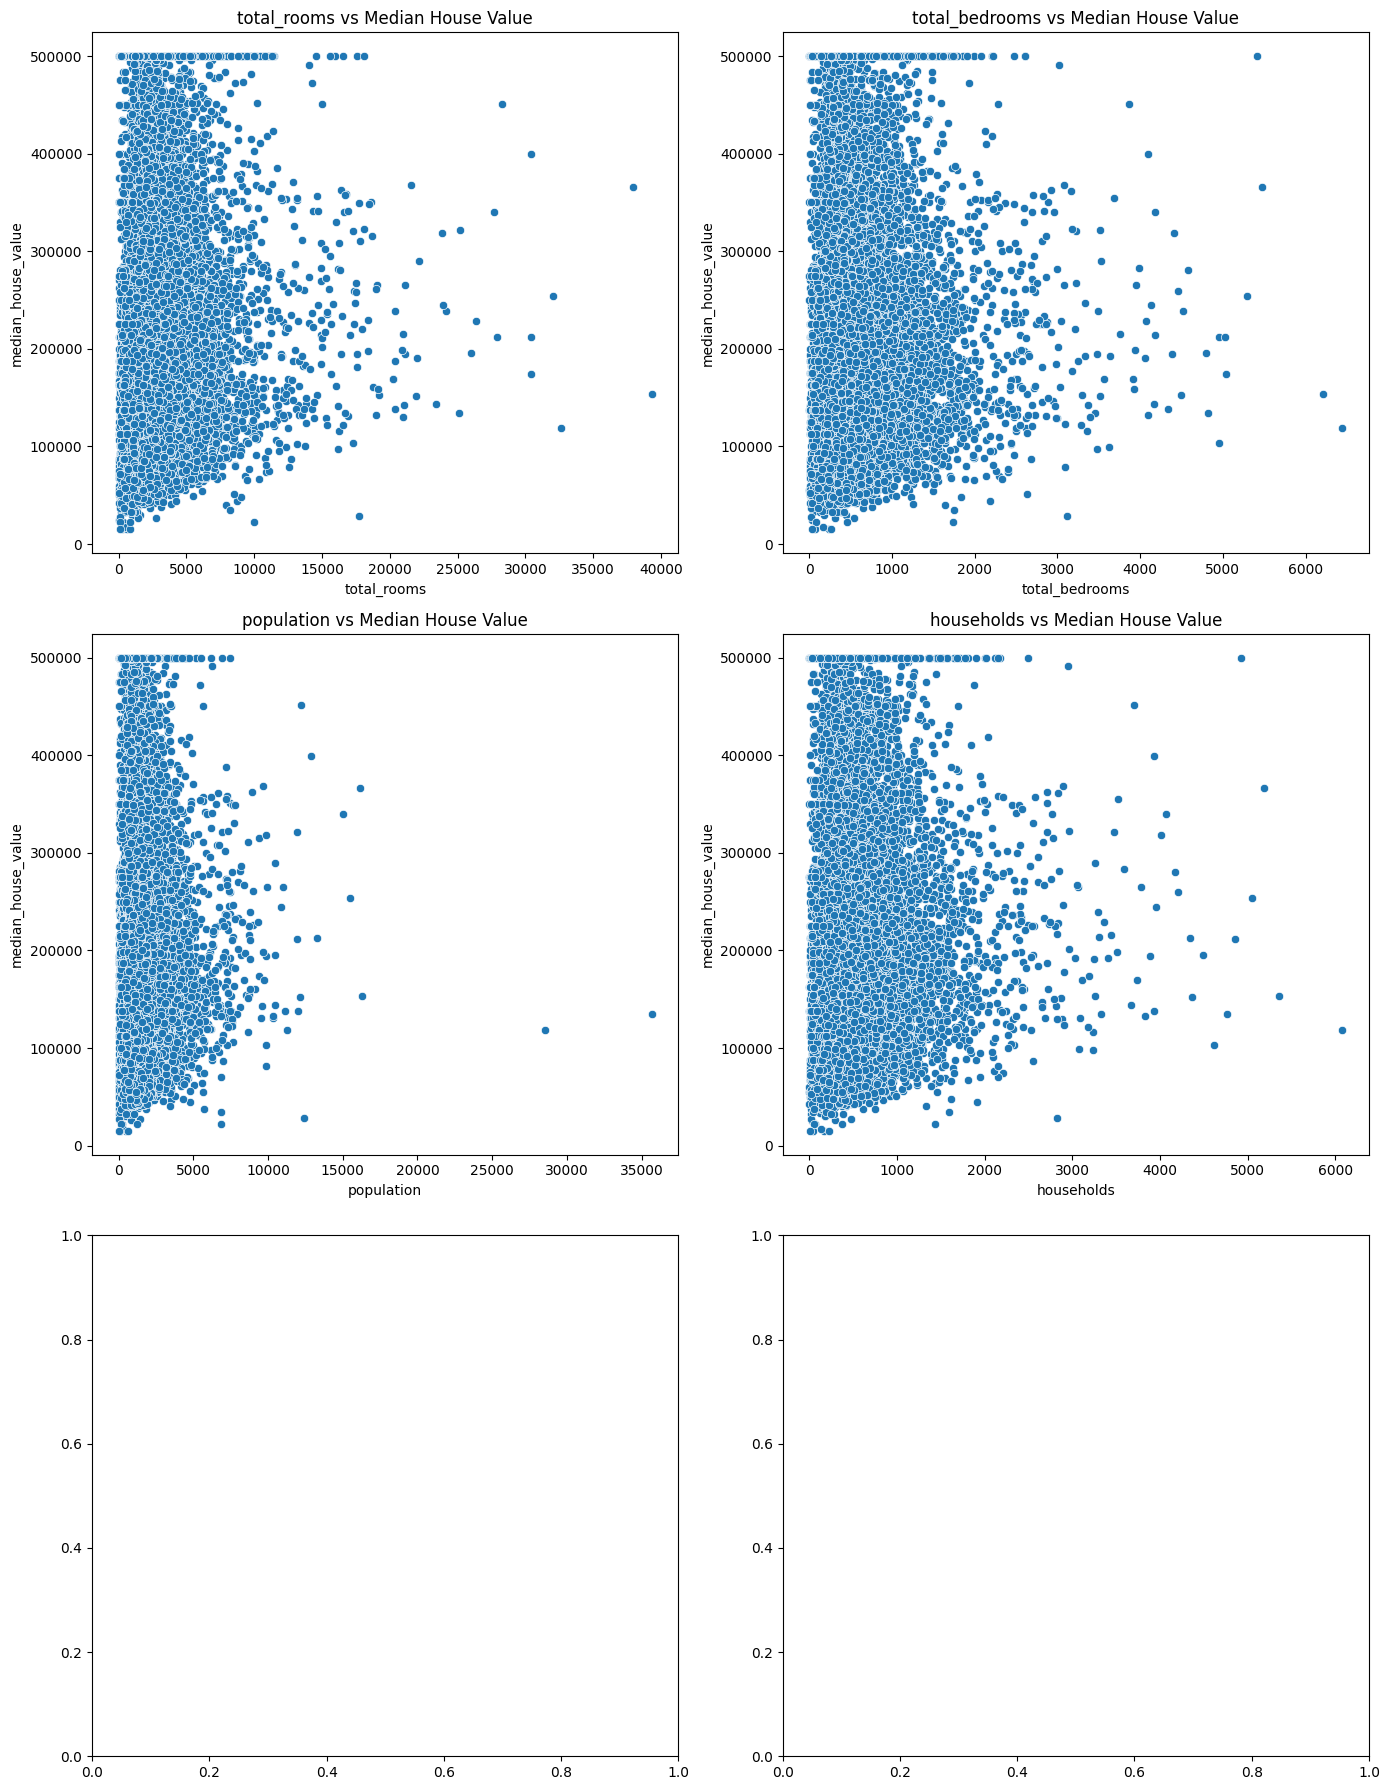

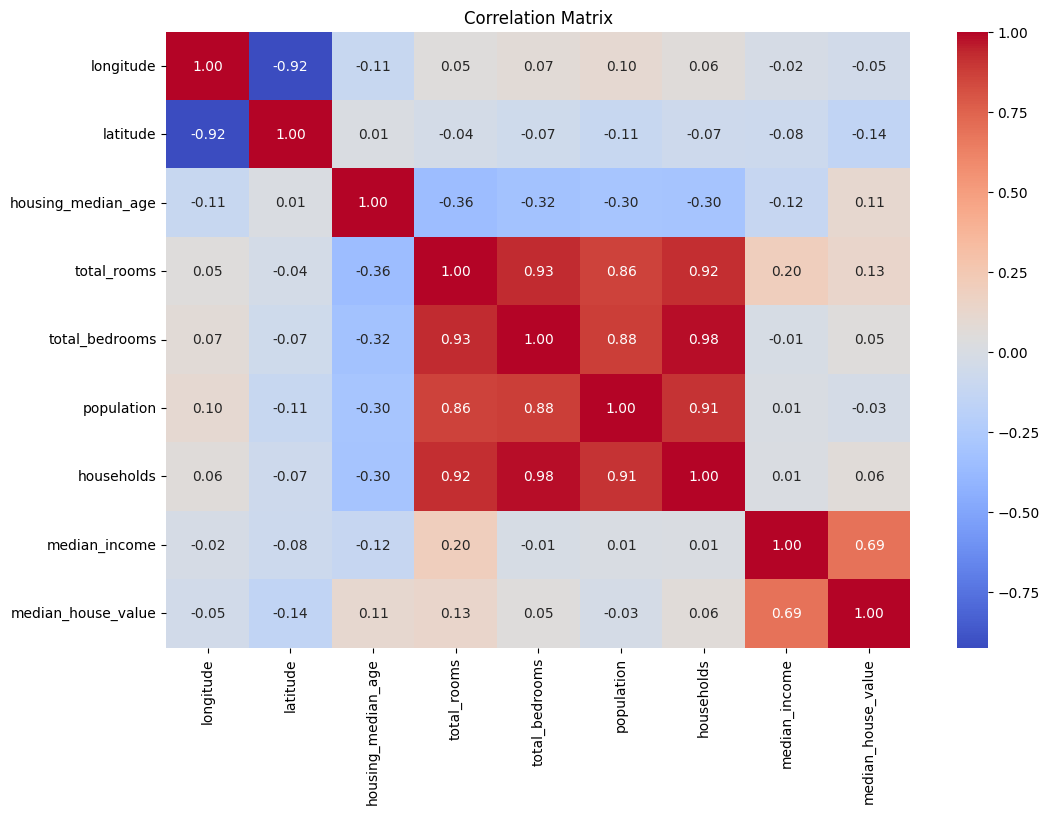

In [3]:
# Run the main function
if __name__ == "__main__":
    main()